# Keterangan Tugas

Film Junky Union, sebuah komunitas baru bagi penggemar film klasik sedang mengembangkan sistem untuk memfilter dan mengategorikan ulasan film. Misi utamanya adalah melatih model agar bisa mendeteksi ulasan negatif secara otomatis. Anda akan menggunakan *dataset* ulasan film IMBD dengan pelabelan polaritas untuk membuat sebuah model yang bisa mengklasifikasikan ulasan positif dan negatif. Model ini setidaknya harus memiliki skor F1 sebesar 0,85.

## Inisialisasi

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
# %matplotlib inline
# %config InlineBackend.figure_format = 'png'
# # baris berikutnya menyediakan grafik dengan kualitas yang lebih baik di layar HiDPI 

# %config InlineBackend.figure_format = 'retina'

# plt.style.use('seaborn')

In [3]:
# ini untuk menggunakan progress_apply, baca lebih lanjut di
# https://pypi.org/project/tqdm/#pandas-integration
# tqdm.pandas()

## Memuat data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
df_reviews.sample(2)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
32052,tt0469189,short,Spatula Madness,Spatula Madness,2005,\N,16,0,"Animation,Music,Short",7.5,244,I've watched it plenty of times and I'm planni...,10,pos,1,train,3748
7578,tt0097074,movie,Cohen and Tate,Cohen and Tate,1988,\N,86,0,"Crime,Thriller",6.4,1899,Having sat and watched this film I can only wo...,2,neg,0,test,8740


In [5]:
df_reviews.shape

(47331, 17)

In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [8]:
df_reviews.duplicated().sum()

0

- Data yang ada memiliki 47331 baris data dan 17 kolom.
- Terdapat sedikit missing value di kolom `average_rating` dan `votes` dengan masing masing mising value nya adalah 2.
- Tidak terdapat duplikasi data.

In [9]:
df_reviews['review'].sample(10)

6126     This movie is so God-awful that it was literal...
597      This movie is not as good as all think. the ac...
1408     Recently, I had opportunity to view a working ...
18547    In Halloween, three friends seek an ancient ce...
18646    Jazz aficionados will treasure this classic sh...
27774    John Wayne is without a doubt one of the most ...
16593    Whether you watch the regular version of this ...
4679     This bogus journey never comes close to matchi...
35597    I have never seen this movie on its own, but l...
32913    Hey now, I can't claim to have seen all of the...
Name: review, dtype: object

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

In [11]:
df_reviews['ds_part'].value_counts()

train    23796
test     23535
Name: ds_part, dtype: int64

**Catatan**

- Karena data yang diperlukan adalah data pada 3 kolom diatas, maka dari itu missing value yang ada diabaikan.

## EDA

Periksa jumlah film dan ulasan selama beberapa tahun.

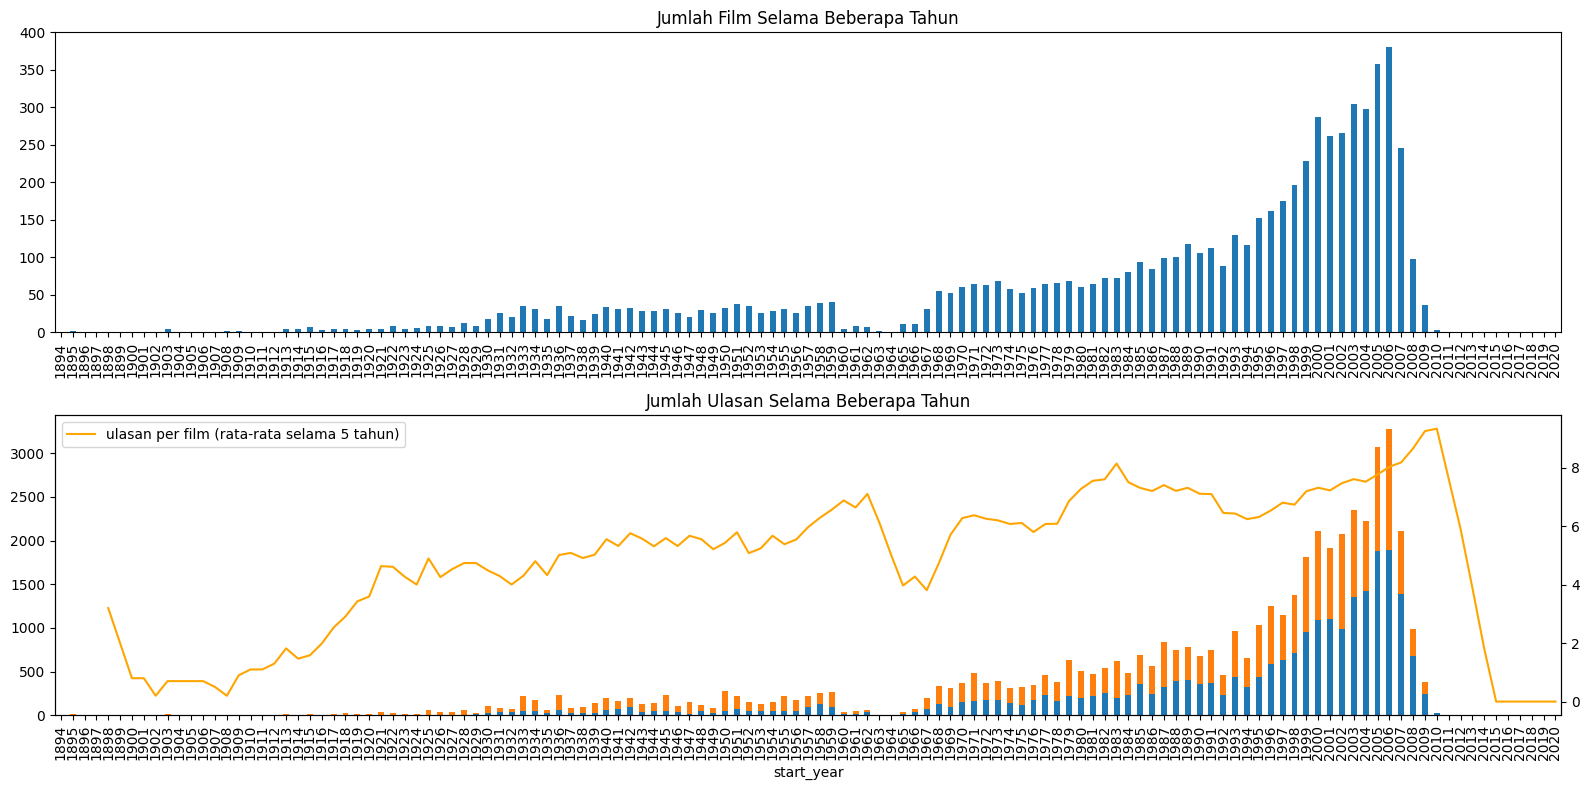

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Jumlah Film Selama Beberapa Tahun')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#ulasan  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='ulasan per film (rata-rata selama 5 tahun)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Jumlah Ulasan Selama Beberapa Tahun') 

fig.tight_layout()

**Temuan**

- Grafik jumlah film selama beberapa tahun menunjukan bahwa dari tahun 1894 s/d 2020 jumlah film mengalami kenaikan yang cukup pesat.
- Kenaikan terjadi pada tahun 1930 sampai 1959, namun terjadi penurunan pada tahun 1960 sampai 1966.
- Kenaikan ke dua yang menjadi patokan kenaikan jumlah film adalah pada tahun 1967. Kenaikannya cukup pesa disini hingga pada tahun 2006. Setelah 2006 jumlah film mengalami penurunan kembali.
- Puncak dari jumlah film berada pada tahun 2006.

Periksa distribusi jumlah ulasan per film dengan penghitungan yang tepat dan KDE (hanya untuk mengetahui perbedaannya dari penghitungan yang tepat)

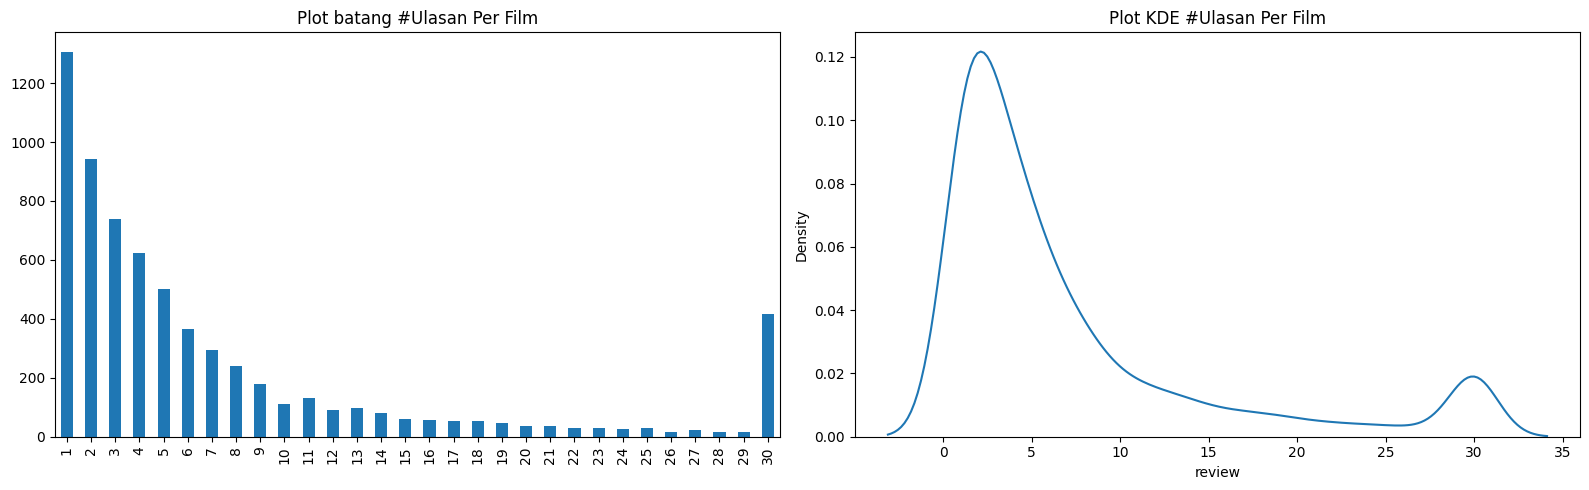

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Plot batang #Ulasan Per Film')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Plot KDE #Ulasan Per Film') 

fig.tight_layout()

In [14]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

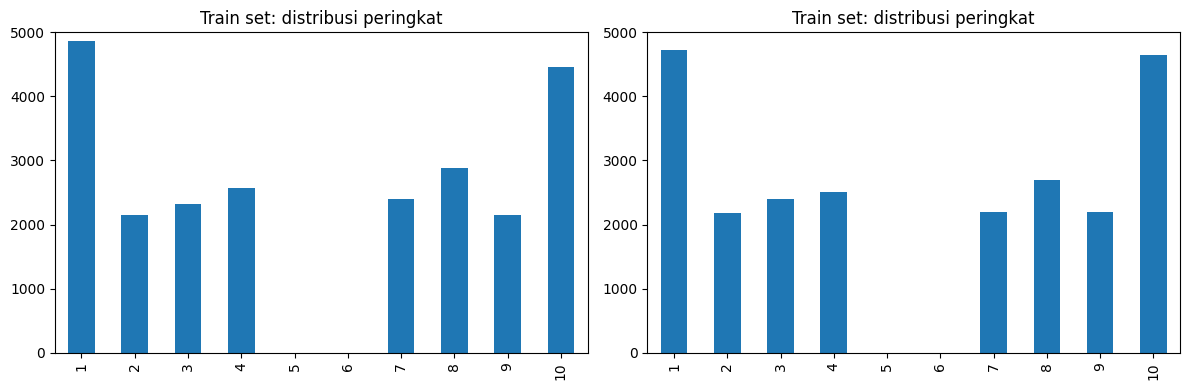

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

fig.tight_layout()

Distribusi ulasan negatif dan positif selama bertahun-tahun untuk dua bagian *dataset*

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


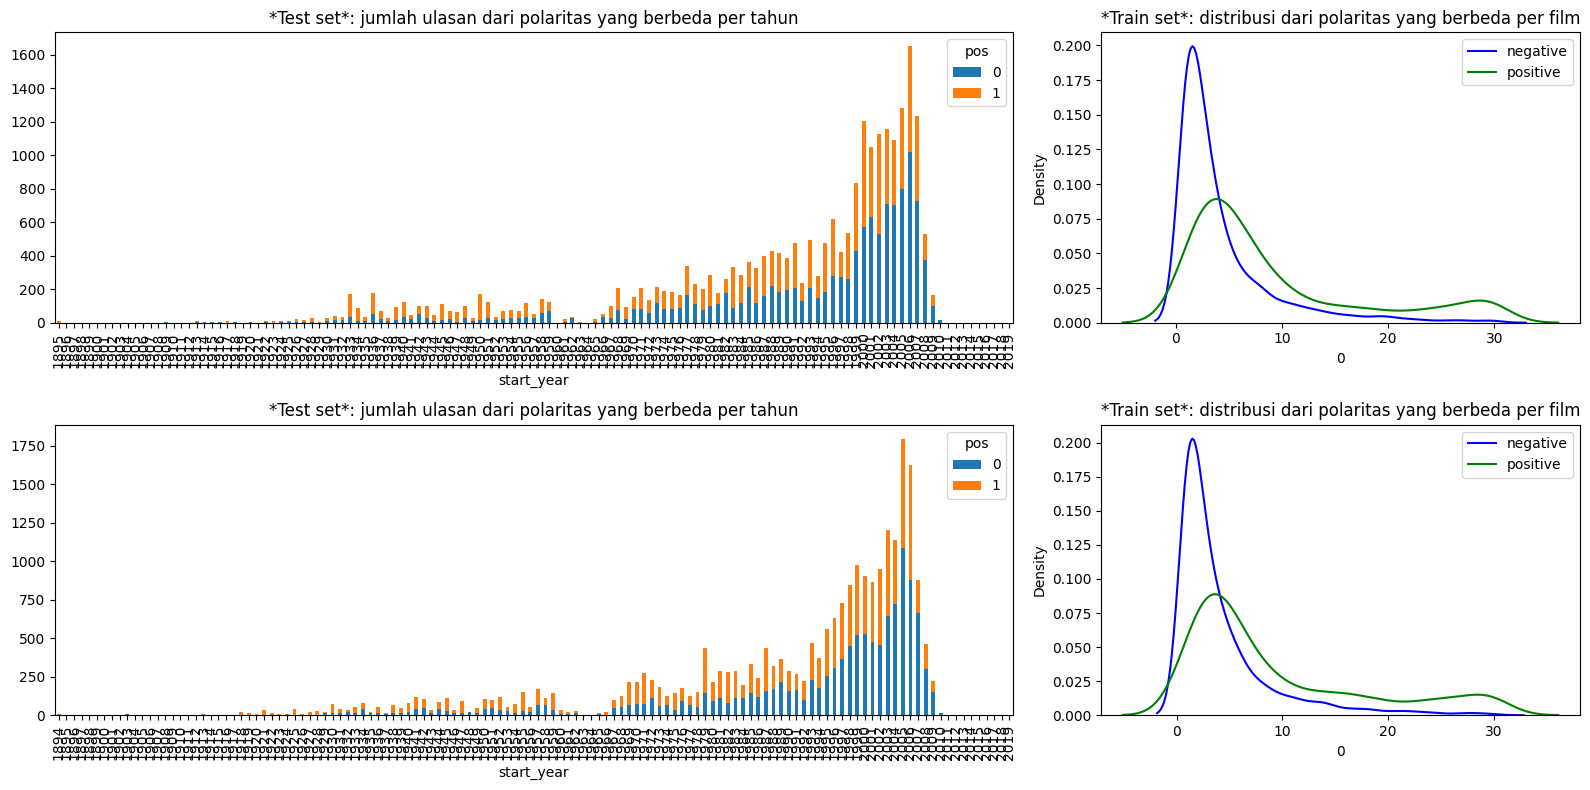

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('*Test set*: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('*Train set*: distribusi dari polaritas yang berbeda per film')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('*Test set*: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('*Train set*: distribusi dari polaritas yang berbeda per film')

fig.tight_layout()

**Temuan**

- Terlihat dari grafik diatas bahwa distribusi dari polaritas ulasan menujunjukan bahwa ulasan negativ cenderung lebih banyak dibandingkan dengan ulasan positif. Hampir setengah dari data pada train set memiliki ulasan positif sedangankan kebanyakannya adalah ulasan yang negatif.

## Prosedur Evaluasi

Menyusun evaluasi yang dapat digunakan untuk semua model dalam tugas ini secara rutin

In [17]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1 
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Kurva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalisasi

Kita menganggap semua model di bawah menerima teks dalam huruf kecil dan tanpa angka, tanda baca, dll.

In [18]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')

In [19]:
df_reviews.head(2)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell did they get this made presenti...


## Pemisahan Train / Test

Untungnya, seluruh *dataset* sudah dibagi menjadi *train/test*. Bendera yang sesuai adalah 'ds_part'.

In [20]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Bekerja dengan Model

Sebelum melatih model, mari buat sebuah baseline atau dummy model untuk standar bawah untuk nilai dari Accuracy,F1, APS dan juga ROC AUC.

### Model 0 - Konstan

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


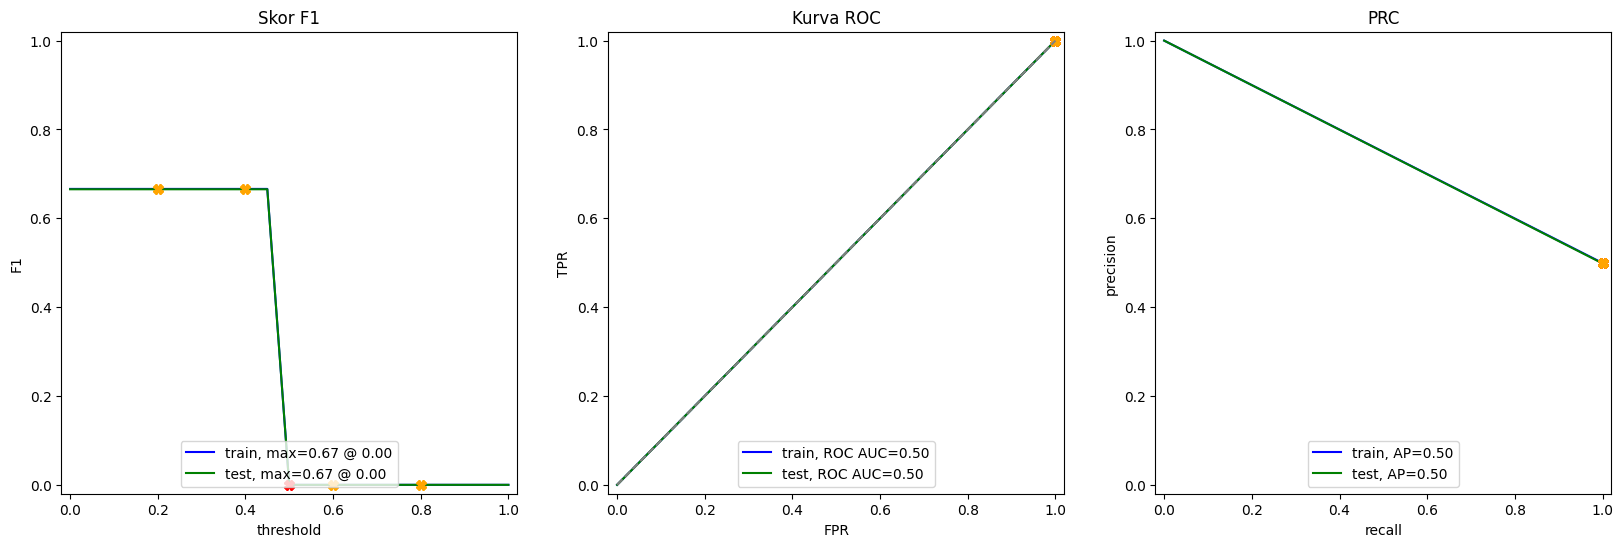

In [21]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='prior')

model_dummy1 = dummy_clf.fit(X=df_reviews_train, y=train_target)

evaluate_model(model_dummy1, np.empty(len(train_target)), train_target, np.empty(len(test_target)), test_target)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


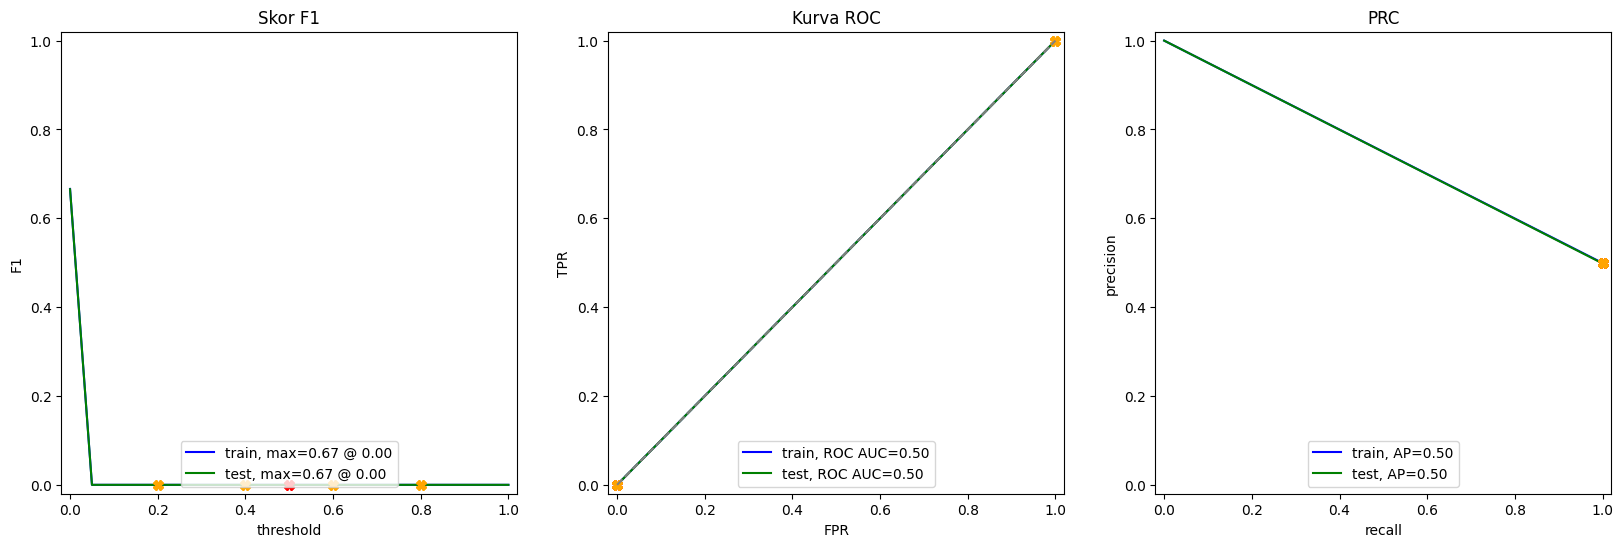

In [22]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='constant', constant=0)

model_dummy = dummy_clf.fit(X=df_reviews_train, y=train_target)

evaluate_model(model_dummy, np.empty(len(train_target)), train_target, np.empty(len(test_target)), test_target)

**Temuan**

- Model dummy dibuat dengan 2 parameter yang berbeda. Model dummy dengan strategy 'prior' dan model dummy dengan strategy constant.
- Pada model dummy dengan stategy 'prior' atau memprediksi kelas mayoritas dalam data yang dilatih, didapat bahwa nilai untuk f1 score adalah 0, namun bila dilihat dari grafik yang ada terlihat bahwa pada threshold 0 hingga 0.5 nilai f1 score berada pada 0.6 dan mengalami penurunan saat threshold 0.5 hingga 1.
- Pada model dummy dengan stategy 'constant' dengan nilai 0, didapat bahwa f1 score memiliki nilai 0 dan bila dilihat dari grafik, pada threshold 0 f1 score berada di 0.6 namun pada saat threshold 0.1 hingga 1, nilai f1 score rata dengan nilai 0.
- Untuk nilai dari TPR dan precisios kedua model dummy memiliki nilai yang sama.
- Dapat dikatakan bahwa 2 model dummy dengan 2 strategy yang berbeda hanya merubah nilai dari f1 score, namun hasil yang didapat dari keduanya adalah sama yaitu f1 score nya 0.

Mari coba dengan strategy yang lain. 

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


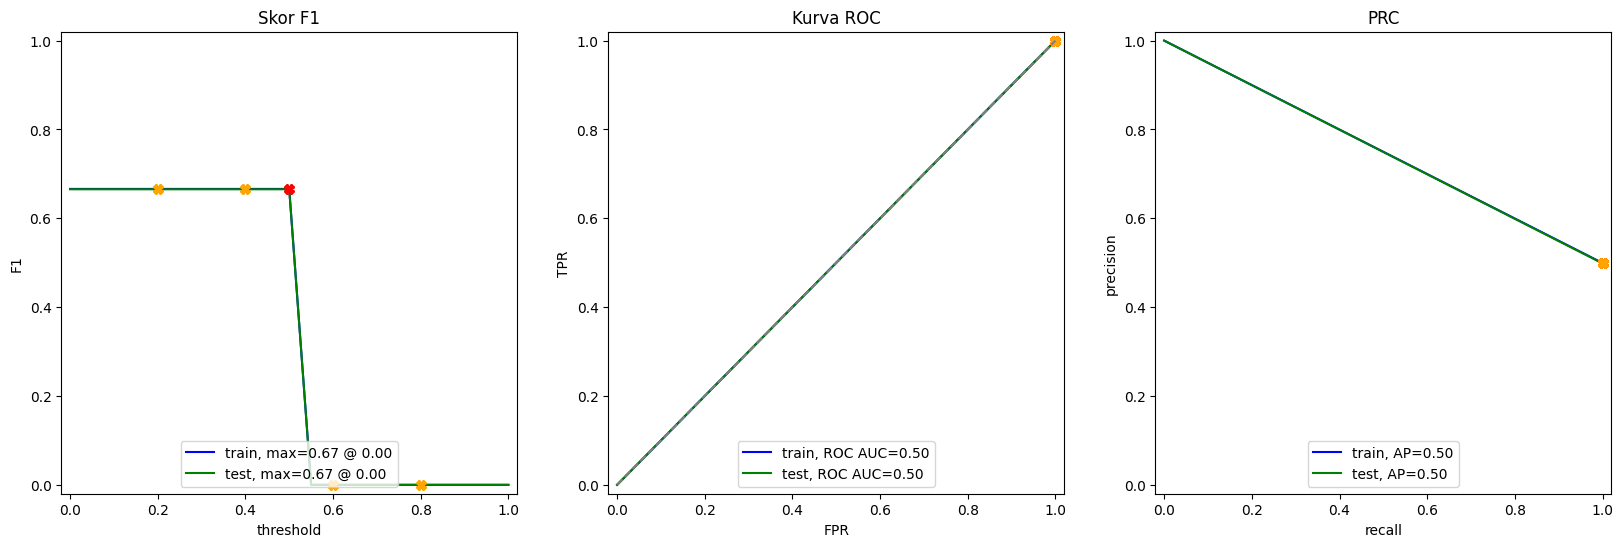

In [23]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='uniform')

model_dummy = dummy_clf.fit(X=df_reviews_train, y=train_target)

evaluate_model(model_dummy, np.empty(len(train_target)), train_target, np.empty(len(test_target)), test_target)

**Temuan**

- Model dummy ke 3 menggunakan strategy 'uniform', yang berarti model akan memprediksi nilai secara acak dengan distribusi seragam pada setiap kelas.
- Didapat f1 score yaitu 0.49, namun bila dilihat dari grafiknya nilai f1 score memiliki maximum score 0.67 dan pada threshold 0.6 hingga 1.0 nilai nya menurun menjadi 0.

Dari 3 model dummy dengan strategy yang berbeda didapat kesimpulan bahwa dataset yang ada baik trainset maupun testset pada saat pelatihan model selanjutnya harus memiliki f1 score yang melampaui nilai maximum dari f1 score dummy diatas yaitu maximum f1 score dari 3 model dummy diatas adalah 0.67. Selanjutnya mari latih model untuk trainset dan test set sesuaindengan istruksi yang diberikan.

### Model 1 - NLTK, TF-IDF dan LR

TF-IDF

In [24]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [25]:
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)

train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
print(train_features_1.shape)

test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])
print(test_features_1.shape)

(23796, 71531)
(23535, 71531)


In [26]:
model_1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.5)
model_1.fit(train_features_1, train_target)

LogisticRegression(C=0.5, penalty='l1', solver='liblinear')

          train  test
Accuracy   0.87  0.87
F1         0.87  0.87
APS        0.94  0.94
ROC AUC    0.94  0.94


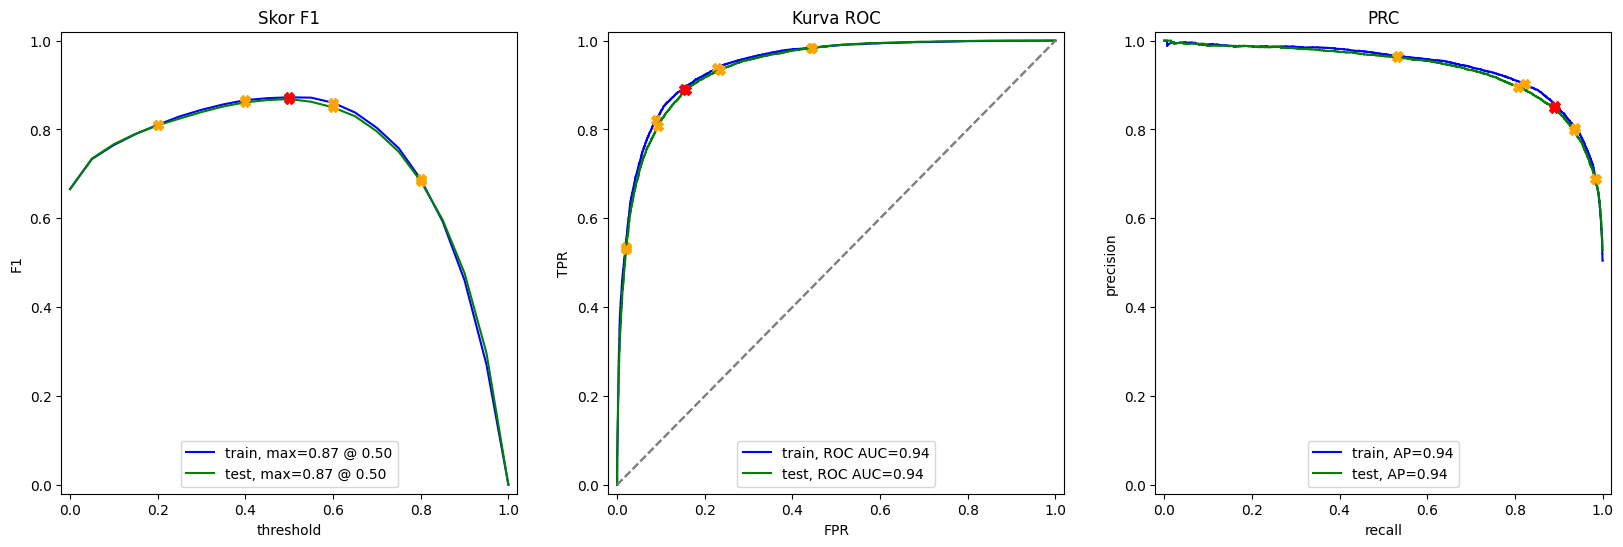

In [27]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

**Catatan**

- Model_1 melatih model dengan LinearRegression dengan bantuan NLTK dan TF-IDF.
- Didapat f1 score 0.87 pada trainset dan testset. 
- Terlihat pada grafik nya bahwa garis kurva cenderung naik dan mengalamu penurunan sebelum mencapai titik threshold 1.0.
- Model_1 f1 scorenya sudah melampaui model dummy dan juga ketentuan yang diberikan yaitu 0.85

### Model 3 - spaCy, TF-IDF dan LR

In [28]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [29]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [30]:
df_reviews_train['review_tokenized_3'] = df_reviews_train['review_norm'].apply(lambda x:text_preprocessing_3(x))

In [31]:
df_reviews_test['review_tokenized_3'] = df_reviews_test['review_norm'].apply(lambda x:text_preprocessing_3(x))

In [32]:
tfidf_vectorized_3 = TfidfVectorizer()

train_features_3 = tfidf_vectorized_3.fit_transform(df_reviews_train['review_tokenized_3'])
print(train_features_3.shape)

test_features_3 = tfidf_vectorized_3.transform(df_reviews_test['review_tokenized_3'])
print(test_features_3.shape)

(23796, 59517)
(23535, 59517)


In [33]:
model_3 = LogisticRegression(penalty='l1', solver='liblinear', C=0.5)
model_3.fit(train_features_3, train_target)

LogisticRegression(C=0.5, penalty='l1', solver='liblinear')

          train  test
Accuracy   0.87  0.87
F1         0.88  0.87
APS        0.94  0.94
ROC AUC    0.95  0.94


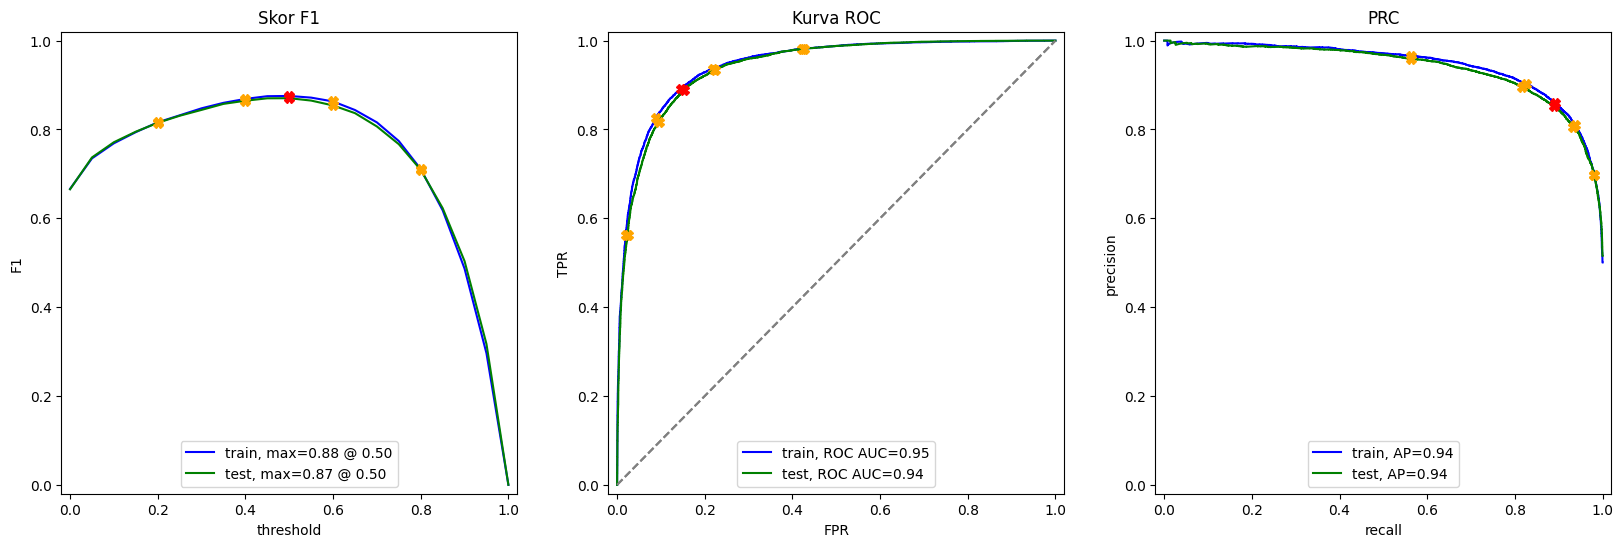

In [34]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

**Catatan**

- Model_3 melatih model dengan LinearRegression dengan parameter yang sama seperti model sebelumnya dan dengan bantuan spaCy dan TF-IDF.
- Didapat f1 score 0.88 pada trainset dan 0.87 pada testset.
- Terlihat pada grafik nya bahwa garis kurva cenderung naik dan mengalami penurunan sebelum mencapai titik threshold 1.0.
- Model_3 f1 scorenya sudah melampaui model dummy dan juga ketentuan yang diberikan yaitu 0.85
- Pada model ini f1 score pada trainset sedikit lebih baik dibandingkan dengan model sebelumnya.

### Model 4 - spaCy, TF-IDF dan LGBMClassifier

In [35]:
from lightgbm import LGBMClassifier

model_4 = LGBMClassifier(learning_rate=0.01, max_depth=4)
model_4.fit(train_features_3, train_target)


LGBMClassifier(learning_rate=0.01, max_depth=4)

          train  test
Accuracy   0.73  0.73
F1         0.77  0.76
APS        0.81  0.81
ROC AUC    0.82  0.82


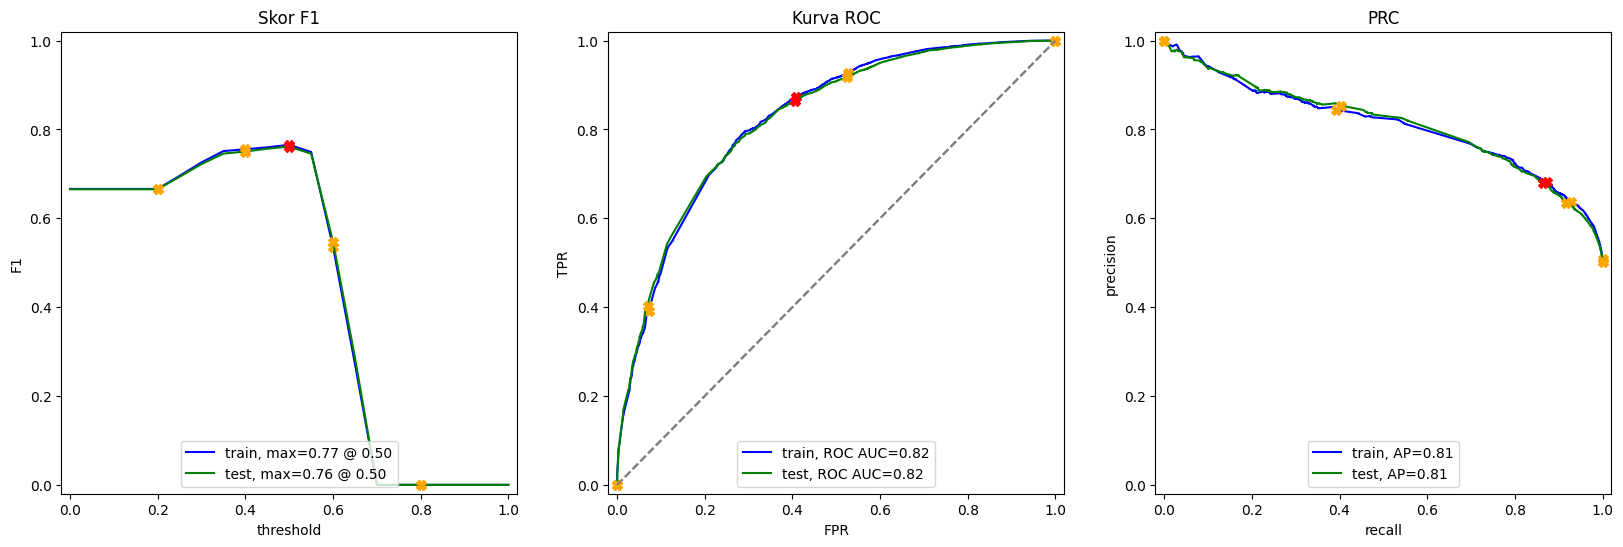

In [36]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

**Catatan**

- Model_4 melatih model dengan gradient bossting yaitu LGBMClassifier dengan bantuan spaCy dan TF-IDF.
- Didapat f1 score 0.77 pada trainset dan 0.76 pada testset.
- Terlihat pada grafik nya bahwa garis kurva cenderung naik pada threshold 0.2 s/d 0.6 dan mengalami penurunan sebelum mencapai titik threshold 1.0.
- Model_4 f1 scorenya sudah melampaui model dummy namun tidak melampaui ketentuan yang diberikan yaitu 0.85
- Pada model ini f1 score pada trainset dan testset mengalami penurunan atau tidak lebih baik dibandingkan dengan model sebelumnya.

###  Model 9 - BERT

Untuk Model BERT, dikarenakan device yang tidak memadai maka dari itu model ini kita skip saja.

In [37]:
# import torch
# import transformers

In [38]:
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# config = transformers.BertConfig.from_pretrained('bert-base-uncased')
# model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [39]:
# def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
#     ids_list = []
#     attention_mask_list = []

#     # teks ke id token yang sudah di-padded bersamaan dengan attention mask
    
#     # <masukkan kode di sini untuk ids_list dan attention_mask_list>
    
#     if force_device is not None:
#         device = torch.device(force_device)
#     else:
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
#     model.to(device)
#     if not disable_progress_bar:
#         print(f'Gunakan {perangkat} perangkat.')
    
#     # dapatkan embedding dalam batch 

#     embeddings = []

#     for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
#         ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
#         # <masukkan kode di sini untuk membuat attention_mask_batch 
            
#         with torch.no_grad():            
#             model.eval()
#             batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
#         embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
#     return np.concatenate(embeddings)

In [40]:
# Perhatian! Menjalankan BERT untuk ribuan teks mungkin memakan waktu lama di CPU, setidaknya beberapa jam
# train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [41]:
# print(df_reviews_train['review_norm'].shape)
# print(train_features_9.shape)
# print(train_target.shape)

In [42]:
# jika sudah mendapatkan embedding, disarankan untuk menyimpannya agar siap 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# dan muat...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

Karena model BERT ini diskip karena device yang tidak mumpuni, maka dari itu langkah selanjutnya yaitu membuat sebuah data frame dan membandingkan ulasan yang dibuat secara manual dengan ulasan yang ada pada dataset. 

## Ulasan Saya

Mari buat sebuah kumpulan ulasan dengan manual dan bandingkan dengan ulasan yang ada di dataset

In [43]:
# jangan ragu untuk menghapus ulasan ini dan mencoba modelmu sendiri terhadap ulasanmu, ini hanya sekadar contoh saja 
my_reviews = pd.DataFrame([
    "I don't like it that much, not my favorite kind of film.",
    "The movie is boring",
    "The film is not good in my opinion",
    "In my opinion, the film is not of good quality and the direction of the story is not clear.",
    "I didn't expect the film to be this good! The writers really paid attention to every detail",
    "The film has it's strengths and weaknesses, but I feel overall it is a decent film. I will probably watch it again.",
    "Some of his jokes are really not funny. Not a single joke works, everyone acts annoying, even the kids won't like this!",
    "Putting this film on Netflix is a bold move & I'm thrilled to be able to watch episode after episode of this engaging and intelligent new drama.",
    "The film is so good, I like it.",
    "I think overall the film is not bad for me and i love the story, it is so clear "
], columns=['review'])

my_reviews['review_norm'] = df_reviews['review'].apply(lambda x:text_preprocessing_3(x))
my_reviews

,review,review_norm
0,"I don't like it that much, not my favorite kin...",the pakage imply that Warren Beatty and Goldie...
1,The movie is boring,how the hell do they get this make ? ! present...
2,The film is not good in my opinion,there be no real story the film seem more like...
3,"In my opinion, the film is not of good quality...",um .... a serious film about troubled teen in ...
4,I didn't expect the film to be this good! The ...,I be totally agree with GarryJohal from Singap...
5,"The film has it's strengths and weaknesses, bu...",this be the first movie I 've see from Singapo...
6,Some of his jokes are really not funny. Not a ...,yes non - singaporean 's can not see what be t...
7,Putting this film on Netflix is a bold move & ...,this true story of Carlson 's Raiders be more ...
8,"The film is so good, I like it.",should have be title ' Balderdash ! ' little i...
9,I think overall the film is not bad for me and...,the movie ' Gung Ho ! ' : the Story of Carlson...


Terdapat 10 ulasan dengan kategori ulasan yang berbeda. Ulasan-ulasan tersebut 

### Model 2

In [44]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.04:  the pakage imply that Warren Beatty and Goldie Hawn be pull off a huge bank robbery , but that be no
0.08:  how the hell do they get this make ? ! present itself as a caper comedy , the misbegotten " $ " be e
0.42:  there be no real story the film seem more like a fly on the wall drama - documentary than a proper f
0.77:  um .... a serious film about troubled teen in Singapore , a country I have not much knowledge on but
0.38:  I be totally agree with GarryJohal from Singapore 's comment about this film . quotation : ' yes non
0.94:  this be the first movie I 've see from Singapore and it be great . if you do not know a lot about As
0.76:  yes non - singaporean 's can not see what be the big deal about this film . some of the reference in
0.54:  this true story of Carlson 's Raiders be more of a Army training film than anything else . obviously
0.56:  should have be title ' Balderdash ! ' little in the film be true except the name of the island and t
0.68:  the movie ' Gung Ho !

### Model 3

In [45]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorized_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.01:  the pakage imply that Warren Beatty and Goldie Hawn be pull off a huge bank robbery , but that be no
0.07:  how the hell do they get this make ? ! present itself as a caper comedy , the misbegotten " $ " be e
0.31:  there be no real story the film seem more like a fly on the wall drama - documentary than a proper f
0.54:  um .... a serious film about troubled teen in Singapore , a country I have not much knowledge on but
0.49:  I be totally agree with GarryJohal from Singapore 's comment about this film . quotation : ' yes non
0.95:  this be the first movie I 've see from Singapore and it be great . if you do not know a lot about As
0.85:  yes non - singaporean 's can not see what be the big deal about this film . some of the reference in
0.61:  this true story of Carlson 's Raiders be more of a Army training film than anything else . obviously
0.59:  should have be title ' Balderdash ! ' little in the film be true except the name of the island and t
0.66:  the movie ' Gung Ho !

### Model 4

In [46]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorized_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.24:  the pakage imply that Warren Beatty and Goldie Hawn be pull off a huge bank robbery , but that be no
0.43:  how the hell do they get this make ? ! present itself as a caper comedy , the misbegotten " $ " be e
0.47:  there be no real story the film seem more like a fly on the wall drama - documentary than a proper f
0.24:  um .... a serious film about troubled teen in Singapore , a country I have not much knowledge on but
0.33:  I be totally agree with GarryJohal from Singapore 's comment about this film . quotation : ' yes non
0.66:  this be the first movie I 've see from Singapore and it be great . if you do not know a lot about As
0.59:  yes non - singaporean 's can not see what be the big deal about this film . some of the reference in
0.58:  this true story of Carlson 's Raiders be more of a Army training film than anything else . obviously
0.56:  should have be title ' Balderdash ! ' little in the film be true except the name of the island and t
0.53:  the movie ' Gung Ho !

### Model 9

In [47]:
# texts = my_reviews['review_norm']

# my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

# my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

# for i, review in enumerate(texts.str.slice(0, 100)):
#     print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Kesimpulan

Ada beberapa kesimpulan dari langkah-langakh yang telah dilakukan, diantaranya:

1. Data yang ada memiliki 47331 baris data dan 17 kolom. Terdapat sedikit missing value di kolom average_rating dan votes dengan masing masing mising value nya adalah 2. Tidak terdapat duplikasi data.
2. Karena data yang diperlukan adalah data pada 3 kolom diatas, maka dari itu missing value yang ada diabaikan.
3. Grafik jumlah film selama beberapa tahun menunjukan bahwa dari tahun 1894 s/d 2020 jumlah film mengalami kenaikan yang cukup pesat. Kenaikan terjadi pada tahun 1930 sampai 1959, namun terjadi penurunan pada tahun 1960 sampai 1966. Kenaikan ke dua yang menjadi patokan kenaikan jumlah film adalah pada tahun 1967. Kenaikannya cukup pesa disini hingga pada tahun 2006. Setelah 2006 jumlah film mengalami penurunan kembali. Puncak dari jumlah film berada pada tahun 2006.
4. Pemodelan:
    - Model_1 - NLTK, TF-IDF dan LogisticRegression  
        - Accuracy
            - train: 0.87 & test: 0.87
        - F1
            - train: 0.87 & test: 0.87
        - APS
            - train: 0.94 & test: 0.94
        - ROC AUC
            - train: 0.94 & test: 0.94
    - Model_3 Spicy, TF-IDF dan LogisticRegression  
        - Accuracy
            - train: 0.87 & test: 0.87
        - F1
            - train: 0.88 & test: 0.87
        - APS
            - train: 0.94 & test: 0.94
        - ROC AUC
            - train: 0.95 & test: 0.94
    - Model_4 - spaCy, TF-IDF dan LGBMClassifier
        - Accuracy
            - train: 0.73 & test: 0.73
        - F1
            - train: 0.77 & test: 0.76
        - APS
            - train: 0.81 & test: 0.81
        - ROC AUC
            - train: 0.82 & test: 0.82
            
            
5. Dari model-model yang telah dilatih, Model_3 yang menggunakan LogisticRegression dengan bantuan Spicy dan juga TF-IDF  memiliki f1 score yang terbaik dibandingkan dengan kedua model yang lain. Model_3 ini memiliki f1 score 0.88 untuk trainset dan 0.87 untuk testset, keduannya sudah melampaui score yang dibuat oleh model dummy dan juga sudah melampaui kententuan yang diberikan yaitu 0.85. 
6. Dari sekian ulasan yang ada rata-rata ulasan negatif yang ada adalah mengenai genre dari sebuah film tersebut, ada yang menyatakan tidak sesuai, ada juga yang menyatakan bahwa film-film tersebut mudah tertebak alur ceritanya, ada pula yang menyatakan bahwa film nya membosankan. Semua rata-rata ulasan negatif yang ada dapat dikategorikan sebagai ulasan yang mengkritik ke genre yang ada di film-film tersebut.


# Daftar Periksa

- [x]  *Notebook* dibuka 
- [ ]  Data teks telah dimuat dan dilakukan pra-pemrosesan untuk vektorisasi 
- [ ]  Data teks telah diubah menjadi vektor 
- [ ]  Model telah terlatih dan diuji 
- [ ]  Ambang batas metrik tercapai 
- [ ]  Semua kode sel tersusun sesuai urutan eksekusinya 
- [ ]  Semua kode sel bisa dieksekusi tanpa *error* 
- [ ]  Terdapat kesimpulan 